# Creating Scalable NLP pipelines using PySpark and Nlphose

> This notebook was tested on Google Data
In this article we will see how we can use Nlphose along with Pyspark to execute a NLP pipeline and gather information about  Phileas Fogg's famous journey from Jules Verne's book ' Around the World in 80 days'.

From my personal experience what I have found is data mining from unstructured data requires using of multiple techniques. There is no single model or library that typically offers everything you need. Often you may need to use components written in different programing languages/frameworks. This is where my open source project Nlphose comes into picture. Nlphose enables creation of complex NLP pipelines in seconds, for processing static files or streaming text, using a set of simple command line tools. Perform multiple operation on text like NER, Sentiment Analysis, Chunking, Language Identification, Q&A, 0-shot Classification and more by executing a single command in the terminal. Spark is widely used big data processing tool  

Nlphose is based on the ' Unix tools philosophy'. The idea is to create simple tools which can work together to accomplish multiple tasks. Nlphose scripts rely on standard 'Filestreams' to read and write data and can be piped together to create complex natural language processing pipelines. Every scripts reads JSON from 'Standard Input' and writes to 'Standard Output'. All the script expect JSON to be encoded in nlphose compliant format and the output also needs to be nlphose compliant. 

## How is Nlphose different ?
Nlphose by design does not support Spark/Pyspark natively like SparkML. What we do to use Nlphose in Pyspark is rely on 'Docker' being installed on all nodes of the Spark cluster. This is easy to do when creating a new cluster in Google Dataproc (and should be same for any other Spark distribution). Apart from Docker Nlphose does not require any other dependency to be installed on  worker nodes of the Spark cluster. We use 'PipeLineExecutor' executor module to execute Nlphose pipeline from within Pyspark.

Under the hood, this module the 'subprocess' module to spwan a new docker container for Spark task and execute a Nlphose pipeline. I/O is performed using stdout and stdin. This sounds very unsophisticated but that's how I build Nlphose. It was never envisioned to support any specific computing framework or library. You can run Nlphose in many different ways, one of which is being documented in this document.

## Let's begin
First we install a package which we will use later to construct a visualization.

In [1]:
!pip install wordcount

The below command downloads the ebook 'Around the world in 80 days' from gutenber.org and uses a utility provided by Nlphose to segment the single text file into line delimited json. Each json object has an 'id' and 'text' attribute.

In [2]:
!docker run code2k13/nlphose:latest \
/bin/bash -c "wget https://www.gutenberg.org/files/103/103-0.txt && ./file2json.py 103-0.txt -n 2"  > ebook.json

--2022-01-24 12:56:45--  https://www.gutenberg.org/files/103/103-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 403521 (394K) [text/plain]
Saving to: ‘103-0.txt’

     0K .......... .......... .......... .......... .......... 12%  739K 0s
    50K .......... .......... .......... .......... .......... 25% 1.43M 0s
   100K .......... .......... .......... .......... .......... 38%  100M 0s
   150K .......... .......... .......... .......... .......... 50% 1.46M 0s
   200K .......... .......... .......... .......... .......... 63%  115M 0s
   250K .......... .......... .......... .......... .......... 76%  166M 0s
   300K .......... .......... .......... .......... .......... 88%  140M 0s
   350K .......... .......... .......... .......... ....      100%  136M=0.1s

2022-01-24 12:56:46 (2.81 MB/

We delete all docker containers which we no longer need.

In [3]:
!docker system prune -f

Deleted Containers:
ce854b6a83ba60061eb1af5e5ad932ebb368ecf48ecf4832f2cdcb2387fe41fa

Total reclaimed space: 403.5kB


Let's import all the required libraries. Read the json file which we created earlier and read it into a pandas data frame. Then we append a group_id column which imply assigns a random groupId from 0 to 3, to the rows. Once that is done we create a new PySpark dataframe and display some results.

In [4]:
import pandas as pd
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import udf

In [5]:
df_pd = pd.read_json("ebook.json",lines=True) 

In [6]:
df_pd['group_id'] = [i for i in range(0,3)]*347

In [7]:
df= spark.createDataFrame(df_pd)

In [8]:
df= spark.createDataFrame(df_pd)

## Running the nlphose pipeline using Pyspark

As discussed earlier Nlphose does not have native integration with Pyspark/Spark. So we create a class called 'PipeLineExecutor' that starts a docker container and executes a Nlphose command. This class communicates with the docker container using 'stdin' and 'stdout'. Finally when the docker container completes execution, we execute 'docker system prune -f' to clear any unused containers.The 'execute_pipeline' method writes data from dataframe to stdin (line by line), reads output from stdout and returns a dataframe from the output.

In [9]:
import subprocess
import pandas as pd
import json

class PipeLineExecutor:
  def __init__(self, nlphose_command,data,id_column='id',text_column='text'):
    self.nlphose_command = nlphose_command
    self.id_column = id_column
    self.text_column = text_column
    self.data = data

  def execute_pipeline(self):
    try:
     prune_proc = subprocess.Popen(["docker system prune -f"],shell=True)
     prune_proc.communicate()
        
     proc = subprocess.Popen([self.nlphose_command],shell=True,stdout=subprocess.PIPE, stdin=subprocess.PIPE,stderr=subprocess.PIPE)
     for idx,row in self.data.iterrows():       
        proc.stdin.write(bytes(json.dumps({"id":row[self.id_column],"text":row[self.text_column]}),"utf8"))
        proc.stdin.write(b"\n")
        proc.stdin.flush()
    
     output,error = proc.communicate()
     output_str = str(output,'utf-8')
     output_str = output_str
     data = output_str.split("\n")    
     data = [d for d in data if len(d) > 2]
    finally:
        prune_proc = subprocess.Popen(["docker system prune -f"],shell=True)
        prune_proc.communicate()
    return pd.DataFrame(data)
    

## The Nlphose command

The below commands does multiple things:
* It starts a docker conainer using code2k13/nlphose:latest image from dockerhub.
* It redirects stdin, stdout and stderr of host into docker container.
* Then it runs a nlphose command inside the docker container which perfroms below operations on json coming from 'stdin' and writes output to stdout:
    * Entity Recognition
    * Finding answer to question 'What did they carry?' using Transformer model.

In [10]:
command =  '''
docker run -a stdin -a stdout -a stderr   -i code2k13/nlphose:latest   /bin/bash -c  "./entity.py |\
./xformer.py --pipeline question-answering --param 'what did they carry?' 
" 
'''

The below function uses the formats data returned by PipelineExecutor task. The dataframe returned by 'PipelineExecutor.execute_pipeline' returns a dataframe with single string column containing output from the Nlphose command. Each row in the dataframe contains a line/document output from the Nlphose command.

In [11]:
def get_answer(row):
  try:
    x =  json.loads(row[0],strict=False)
    row['json_obj'] = json.dumps(x)
    if x['xfrmr_question_answering']['score'] > 0.80:
        row['id'] =  str(x['id'])
        row['answer'] = x['xfrmr_question_answering']['answer']        
    else:
        row['id'] = str(x['id'])
        row['answer'] = None
        
  except Exception as e:
    row['id'] = None
    row['answer'] = "ERROR " + str(e) #.message
    row['json_obj'] = None
    
  return row

The below function, creates a 'PipeLineExecutor' object, passes on data to it and then calls the 'execute_pipeline' method on the object. Then it uses the 'get_answer' method to format the outout of the 'execute_pipeline' method.  

In [12]:
def run_pipeline(data):
    nlphose_executor = PipeLineExecutor(command,data,"id","text")
    result = nlphose_executor.execute_pipeline()
    result =  result.apply(get_answer,axis=1)     
    return  result[["id","answer","json_obj"]]  

## Scaling the pipeline using PySpark

We use the 'applyInPandas' from PySpark to parallelize and process text at scale. PySpark automatically handles scaling of the Nlphose pipleline on the Spark cluster. The 'run_pipeline' method is invoked for every 'group' of the input data. It is important to have appropriate number of groups so as to efficiently process data on the Spark cluster.

In [13]:
output = df.groupby("group_id").applyInPandas(run_pipeline, schema="id string,answer string,json_obj string")
output.cache()

DataFrame[id: string, answer: string, json_obj: string]

## Visualizing our findings

Once we are done executing the nlphose pipeline, we setout to visualize our findings. In the below code, I have create two visualizations:

* A map showing places mentioned in the book
* A word cloud of all the important items the charactors carried for their journey.

## Plotting most common locations from the book on world map

The below code extracts  latitude and longitude information from Nlphose pipeline and creates a list of most common locations.

> Note: Nlphose entity extraction will automatically guess cordinates for well known locations using dictionary based approach

In [14]:
 def get_latlon2(data):
        json_obj = json.loads(data)
        if 'entities' in json_obj.keys():
            for e in json_obj['entities']:
                if e['label'] == 'GPE' and 'cords' in e.keys():
                    return json.dumps({'data':[e['entity'],e['cords']['lat'],e['cords']['lon']]})
        return None
        
get_latlon_udf2 = udf(get_latlon2)        

In [15]:
df_locations = output.withColumn("locations",get_latlon_udf2(output["json_obj"]))

In [16]:
top_locations = df_locations.filter("`locations` != 'null'").groupby("locations").count().sort(desc("count")).filter("`count` >= 1")
top_locations.cache() 
top_locations.show()

+--------------------+-----+
|           locations|count|
+--------------------+-----+
|{"data": ["London...|   36|
|{"data": ["Hong K...|   31|
|{"data": ["Bombay...|   26|
|{"data": ["Yokoha...|   16|
|{"data": ["India"...|   15|
|{"data": ["Omaha"...|   13|
|{"data": ["San Fr...|   12|
|{"data": ["Liverp...|   11|
|{"data": ["New Yo...|   11|
|{"data": ["Allaha...|   10|
|{"data": ["Englan...|    9|
|{"data": ["Americ...|    7|
|{"data": ["the Un...|    7|
|{"data": ["Singap...|    6|
|{"data": ["Paris"...|    6|
|{"data": ["Japan"...|    6|
|{"data": ["China"...|    6|
|{"data": ["Aden",...|    5|
|{"data": ["Shangh...|    5|
|{"data": ["U.S.",...|    4|
+--------------------+-----+
only showing top 20 rows



Then we use 'geopandas' to plot these locations on a world map. Before we do that we will have to transform our dataframe to the format understood by 'geopandas' . This is done by applying the function 'add_lat_long'

In [17]:
def add_lat_long(row):
     obj =  json.loads(row[0])["data"]
     row["lat"] = obj[1]
     row["lon"] = obj[2]
     return row
    

<AxesSubplot:>

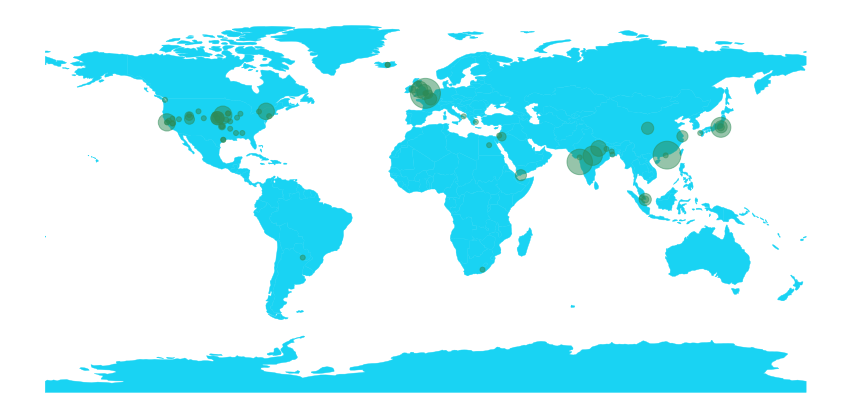

In [18]:
import geopandas

df_locations = top_locations.toPandas()
df_locations = df_locations.apply(add_lat_long,axis=1)

gdf = geopandas.GeoDataFrame(df_locations, geometry=geopandas.points_from_xy(df_locations.lon, df_locations.lat))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color=(25/255,211/255,243/255) ,edgecolor=(25/255,211/255,243/255),
                    linewidth=0.4,edgecolors='none',figsize=(15, 15))
ax.axis('off')   
gdf.plot(ax=ax,alpha=0.5,marker=".",markersize=df_locations['count']*100,color='seagreen')

## Creating a word cloud of items carried Fogg's Journey
The below code finds the most common items carried by the travellers using 'extractive question answering' and creates a word cloud.

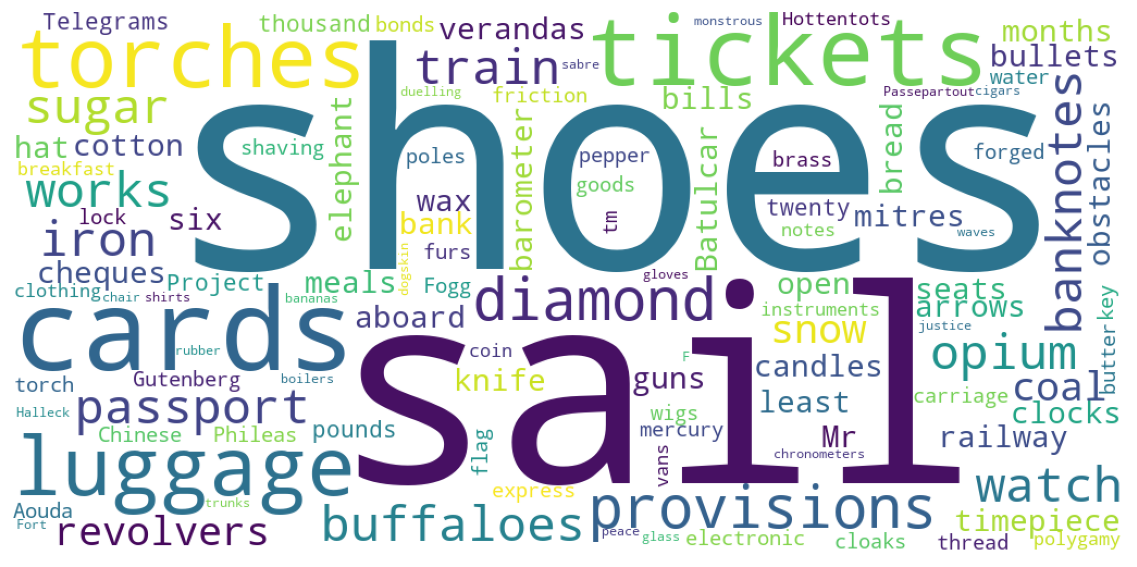

In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=120)
wordcloud = WordCloud(background_color='white',width=1024,height=500).generate(' '.join(output.filter("`answer` != 'null'").toPandas()['answer'].tolist()))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Conclusion

This article shows how we can run Nlphose on a Spark cluster using PySpark. PySpark is a favourite tool of datascientists and ML practitioners because working with dataframes is very convinient. Using the approach described in this article we can embed Nlphose pipeline as part of our data processing pipelines very easily. Hope you liked this article. Feedback and comments are always welcomed, thank you ! 